In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import shap

df = pd.read_excel('Датасет.xlsx')

**1. Предобработка данных**

Посмотрим на пропущенные значения в долях

In [ ]:
pd.set_option('display.max_rows', None)
series_nan_values = (df.isna().sum() / len(df)).sort_values(ascending = False)
series_nan_values.name = 'Nan_values'
series_nan_values

,Nan_values
Т3,0.986014
Т4,0.982018
ТТГ,0.973027
Альбумин,0.940060
ЛДГ,0.920080
Лимфоцитарно-моноцитарное отношение,0.758242
Лимфоциты,0.758242
Моноциты,0.758242
Нейтрофильно-лимфоцитарное отношение,0.758242
Тромбоцитарно-лимфоцитарное отношение,0.758242


Удалим признаки, доля пропущенных значений которых превышает 0.4

In [ ]:
df = df.drop(['Т3', 'Т4', 'ТТГ', 'Альбумин', 'ЛДГ', 'Лимфоцитарно-моноцитарное отношение', 'Лимфоциты', 'Моноциты', 'Нейтрофильно-лимфоцитарное отношение',
              'Тромбоцитарно-лимфоцитарное отношение', 'Саркопения (0 - нет, 1 - да), критерии Prado (ж - <38,5, м- <52,4)',
              'Саркопения 0 - нет, 1 - да (41 для ж, 43 для м ИМТ <25, 53 для м ИМТ >25)', 'Эритроциты', 'Нейтрофилы', 'Общий белок', 'Лейкоциты'], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 52 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)       1001 non-null   int64  
 1   КЗ (Контроль заболевания) (0-нет, 1 - есть)                                              1001 non-null   int64  
 2   Объективный ответ (0-нет, 1 - есть)                                                      1001 non-null   int64  
 3   Токсичность 3-4                                                                          1001 non-null   int64  
 4   Нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак ЖКТ,5- рак шейки матки)  1001 non-null   int64  
 5   возраст                                                       

Для всех признаков типа object выведем уникальные значения

In [ ]:
col_object = ['Вид ИТ', 'АЛТ', 'АСТ', 'Креатинин']

for col in col_object:
    print(col, df[col].unique())

Вид ИТ [10 6 3 4 8 13 1 11 2 '3+деносумаб' 9]
АЛТ [23 nan 26 95 19 15 5 13 18 22 35 7 114 16 28 37 39 10 12 124 6 20 21 14
 31 69 24 40 17 11 41 42 34 30 96 47.4 27 9 8 58 36.5 43 25.1 39.6 53 38 4
 29 25 9.1 33 45 41.9 81 13.1 36 121 10.7 17.2 108 22.6 47 56 97.8 8.6
 37.7 24.8 30.1 19.4 30.5 7.3 12.1 13.2 30.8 72 51 30.2 24.5 '25,7' 32
 '53,8' 14.3 92 19.2 31.5 8.9 116 10.8 25.9 22.3 70 '25,1' 28.8 18.19 54
 '20,1' '18,1' 16.9 59 '11,4' 36.86 '9,8' '48,6' '4,0' 18.75 42.7 44.4
 30.4 98 18.5 41.8 21.3 '24,6' 10.4 14.9 14.43 22.8 '15,48' 30.7 75.8
 '21,5' 12.8 '13,2' 11.9 6.4 7.36 '8,8' 99 9.9 71 10.41 '12,4' 13.6 20.6
 16.8 36.4 12.6 11.5 33.8 29.2 104 90 17.7 14.8 19.5 11.12 9.3 50 26.9
 '15,1' 24.4 9.2 18.8 64 '147,9' datetime.datetime(2021, 4, 15, 0, 0)
 17.18 44295 11.2 44 68 57 15.9 74 11.3 60 82 24.3 49 22.5 167 16.03 17.3]
АСТ [31 nan 65 37 19 24 10 20 15 28 32 70 25 26 22 16 38 43 30 13 14 23 11 18
 27 42 33 17 82 28.6 29 92 20.9 21 20.2 12.25 14.8 24.5 17.5 36 12.31 51
 27.3 

В датасете есть десятичные значения, которые разделены запятой, что неприемлемо для python, поэтому заменим их на точки

In [ ]:
def replace_comma(value):
    if isinstance(value, str) and ',' in value:
        return value.replace(',', '.')
    return value

for column in df.columns:
    df[column] = df[column].apply(replace_comma)

Также в данных были значения в виде дат, которые были переведены в числа

In [ ]:
df.loc[836, ['АЛТ', 'АСТ']] = [15.4, 17.3]

Выберем колонки с пропущенными значениями и будем работать с ними

In [ ]:
column = ['АЛТ', 'Гемоглобин', 'Медиана наилучшего ответа', 'Медиана времени до ответа', 'Медиана длительности ответа', 'Тромбоциты', 'Креатинин', 'АСТ']

In [ ]:
df[['АЛТ', 'АСТ']] = df[['АЛТ', 'АСТ']].astype(float)

Проверим их на наличие выбросов.

Как видно из графиков boxplot в признаках АЛТ и АСТ есть выбросы.

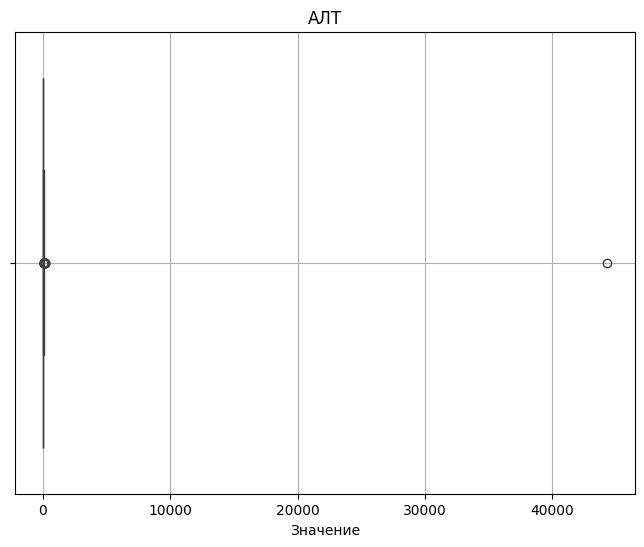

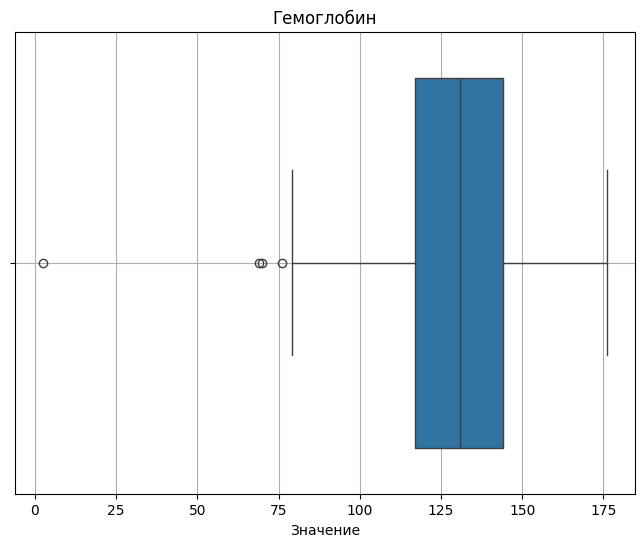

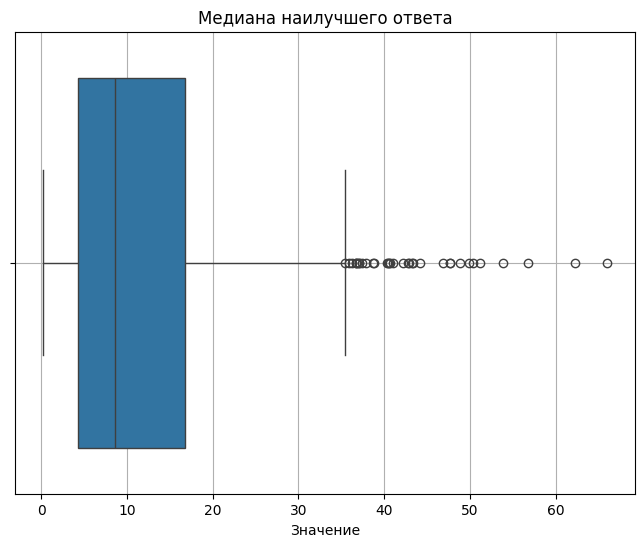

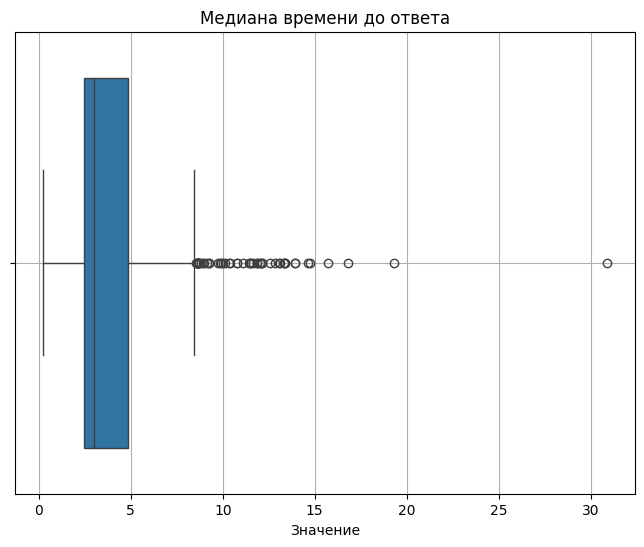

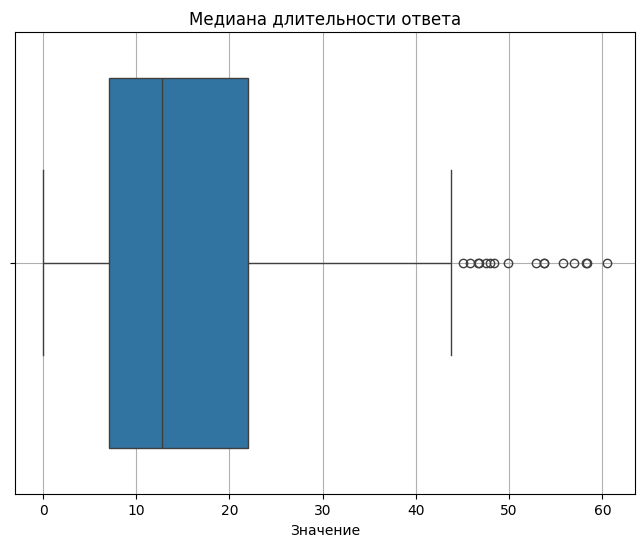

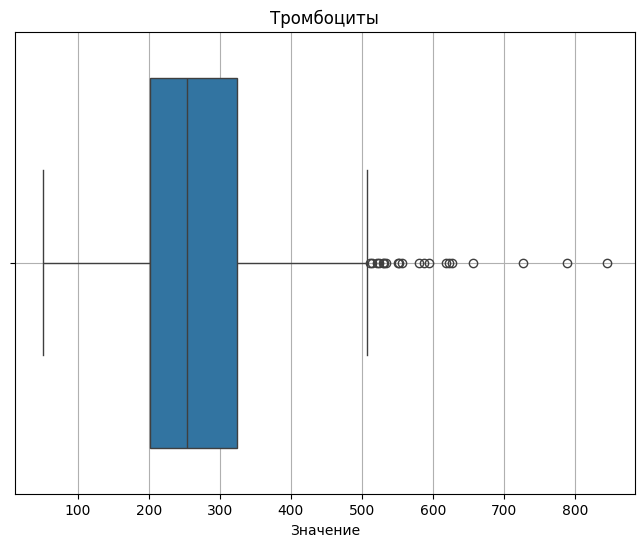

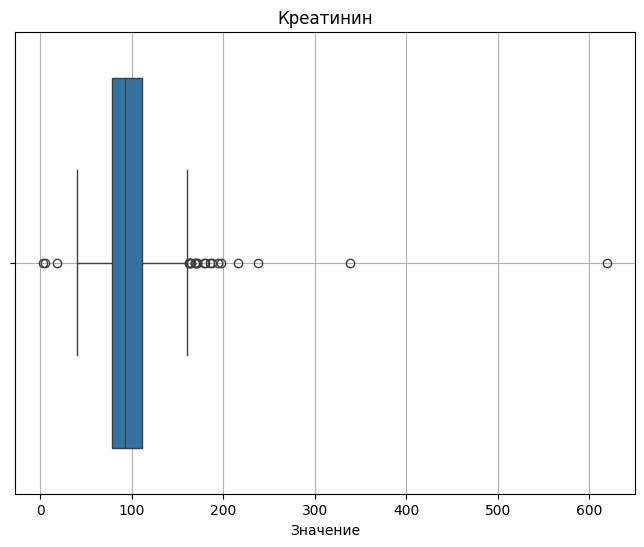

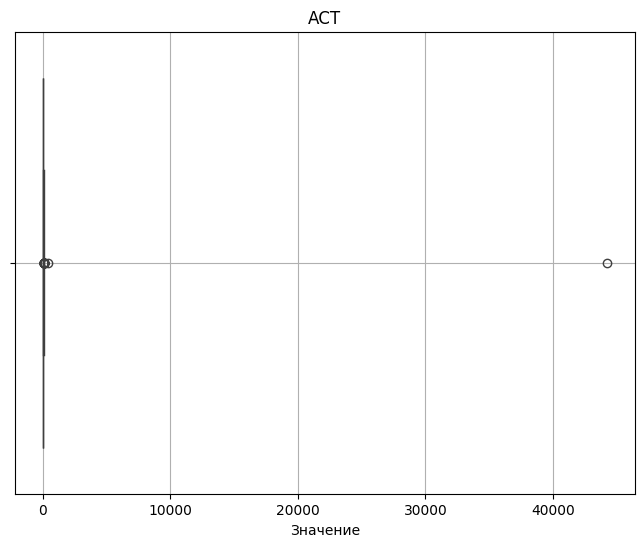

In [ ]:
for col in column:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.xlabel('Значение')
    plt.grid()
    plt.show()

Находим строки с данными выбросами и удаляем эти значения

In [ ]:
df.query("АЛТ > 40000 | АСТ > 40000")

,"ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)","КЗ (Контроль заболевания) (0-нет, 1 - есть)","Объективный ответ (0-нет, 1 - есть)",Токсичность 3-4,"Нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак ЖКТ,5- рак шейки матки)",возраст,"Пол (1-м, 2 - ж)",ECOG,ПМЗО,Сопутствующие. Наличие,...,Вид ИТ,Токсичность 3-4.1,Медиана времени до ответа,Медиана длительности ответа,Медиана наилучшего ответа,Гемоглобин,Тромбоциты,АЛТ,АСТ,Креатинин
872,0,1,1,0,3,76,2,1,2,1,...,1,0,2.7,20.81,17.49,123.0,215.0,44295.0,44209.0,85


In [ ]:
df.loc[872, ['АЛТ', 'АСТ']] = np.nan

Для заполнения пропущенных значений воспользуемся KNNImputer

In [ ]:
imputer = KNNImputer(n_neighbors=3)
df_test = df[column]
filled_data = imputer.fit_transform(df_test)
df_filled = pd.DataFrame(filled_data, columns=df_test.columns)

In [ ]:
df_filled[['АЛТ', 'Гемоглобин', 'Тромбоциты']] = df_filled[['АЛТ', 'Гемоглобин', 'Тромбоциты']].round(1)
df_filled[['Креатинин', 'АСТ']] = df_filled[['Креатинин', 'АСТ']].round(2)

Заменим значения признаков из датасета с пропущенными значениями на новые значения без пропусков

In [ ]:
df.loc[:, column] = df_filled.loc[:, column]

Преобразуем категориальные данные в числовые

In [ ]:
df.loc[df['Вид ИТ'] == '3+деносумаб', 'Вид ИТ'] = 3

In [ ]:
df['Вид ИТ'] = df['Вид ИТ'].astype(int)
df['Креатинин'] = df['Креатинин'].astype(float)

Как видно категориальных данных не осталось

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 52 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)       1001 non-null   int64  
 1   КЗ (Контроль заболевания) (0-нет, 1 - есть)                                              1001 non-null   int64  
 2   Объективный ответ (0-нет, 1 - есть)                                                      1001 non-null   int64  
 3   Токсичность 3-4                                                                          1001 non-null   int64  
 4   Нозология (1- рак почки, 2 - меланома, 3 - рак легкого, 4 - рак ЖКТ,5- рак шейки матки)  1001 non-null   int64  
 5   возраст                                                       

В некоторых таргетных переменных было обнаружено 3 класса вместо 2. Поэтому здесь проводилось преобразование таких признаков к бинарным

In [ ]:
df.loc[df['КЗ (Контроль заболевания) (0-нет, 1 - есть)'] == 2, 'КЗ (Контроль заболевания) (0-нет, 1 - есть)'] = 1
df.loc[df['Объективный ответ (0-нет, 1 - есть)'] == 2, 'Объективный ответ (0-нет, 1 - есть)'] = 1

Разделим данные на признаки и таргеты

In [ ]:
df_targets = df.iloc[:, 0:4]
df_features = df.iloc[:, 4:]

**2. Построение, обучение и оценка модели глубокого обучения**

Проверим таргеты на дисбаланс классов

Видно, что дисбаланс классов присутствует, поэтому при разделении данных будем использовать стратификацию по таргетной колонке


In [ ]:
for i in range(4):
    print(df_targets.iloc[:, i].value_counts() / len(df_targets))

ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)
0    0.693307
1    0.306693
Name: count, dtype: float64
КЗ (Контроль заболевания) (0-нет, 1 - есть)
1    0.819181
0    0.180819
Name: count, dtype: float64
Объективный ответ (0-нет, 1 - есть)
0    0.686314
1    0.313686
Name: count, dtype: float64
Токсичность 3-4
0    0.965035
1    0.034965
Name: count, dtype: float64


In [ ]:
class MedicalNN(nn.Module):
    def __init__(self, input_size):
        super(MedicalNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [ ]:
def train_model_with_scheduler(model, X_train, y_train, criterion, optimizer, scheduler, epochs=60):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if (epoch+1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

In [ ]:
def model_evaluation_with_scheduler(column):
    X_train, X_test, y_train, y_test = train_test_split(df_features, df_targets[column], test_size=0.2, random_state=42, stratify = df_targets[column])
    y_train, y_test = torch.tensor(y_train.values).float(), torch.tensor(y_test.values).float()

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train, X_test = torch.tensor(X_train).float(), torch.tensor(X_test).float()

    input_size = df_features.shape[1]
    model = MedicalNN(input_size)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

    train_model_with_scheduler(model, X_train, y_train, criterion, optimizer, scheduler)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze().round()
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

    print(column)
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

for col in df_targets.columns:
    model_evaluation_with_scheduler(col)

Epoch 5/60, Loss: 0.6106
Epoch 10/60, Loss: 0.5989
Epoch 15/60, Loss: 0.5737
Epoch 20/60, Loss: 0.5566
Epoch 25/60, Loss: 0.5372
Epoch 30/60, Loss: 0.5189
Epoch 35/60, Loss: 0.4981
Epoch 40/60, Loss: 0.4738
Epoch 45/60, Loss: 0.4476
Epoch 50/60, Loss: 0.4176
Epoch 55/60, Loss: 0.3833
Epoch 60/60, Loss: 0.3450
ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)
Accuracy: 0.6716, Precision: 0.6301, Recall: 0.6716, F1-score: 0.6352
Epoch 5/60, Loss: 0.5539
Epoch 10/60, Loss: 0.4879
Epoch 15/60, Loss: 0.4815
Epoch 20/60, Loss: 0.4494
Epoch 25/60, Loss: 0.4298
Epoch 30/60, Loss: 0.4170
Epoch 35/60, Loss: 0.4010
Epoch 40/60, Loss: 0.3865
Epoch 45/60, Loss: 0.3746
Epoch 50/60, Loss: 0.3624
Epoch 55/60, Loss: 0.3504
Epoch 60/60, Loss: 0.3382
КЗ (Контроль заболевания) (0-нет, 1 - есть)
Accuracy: 0.8209, Precision: 0.7661, Recall: 0.8209, F1-score: 0.7491
Epoch 5/60, Loss: 0.6088
Epoch 10/60, Loss: 0.5853
Epoch 15/60, Loss: 0.5520
Epoch 20/60, Loss: 0.5265
Epoch 25

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Для последнего таргета accuracy показывает очень хорошие значение, но это связано с дисбалансом классов. Precision и Recall примерно равны для каждого таргета, т.е. модель способна сбалансировать необходимость обнаружения истинно положительных результатов с необходимостью избегания ложноположительных.

**3. Интерпретация результатов модели**

**Grad-CAM**

Создадим функцию Grad-CAM для анализа признаков конкретного пациента

In [ ]:
def train_model_for_grad_cam(model, X_train, y_train, criterion, optimizer, scheduler, epochs=60):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
def compute_gradcam(model, x, target_class):
    model.eval()
    # Прямой проход
    x.requires_grad = True
    output = model(x)
    model.zero_grad()
    class_loss = output[0][target_class]
    class_loss.backward(retain_graph=True)

    # Получаем градиенты и активации для последнего полносвязного слоя
    gradients = model.fc3.weight.grad  # Пример для последнего слоя
    activations = model.fc3.weight

    # Умножаем активации на градиенты для вычисления важности
    weights = torch.mean(gradients, dim=0)
    cam = torch.sum(weights * activations, dim=0).detach().cpu().numpy()
    return cam

In [ ]:
def barplot(dicts, title):
    plt.figure(figsize=(10, 10))
    plt.barh(range(input_size), dicts.values())
    plt.ylabel('Признаки')
    plt.xlabel('Важность признаков')
    plt.title(title)
    plt.yticks(range(input_size), dicts.keys())
    plt.tight_layout()
    plt.show()

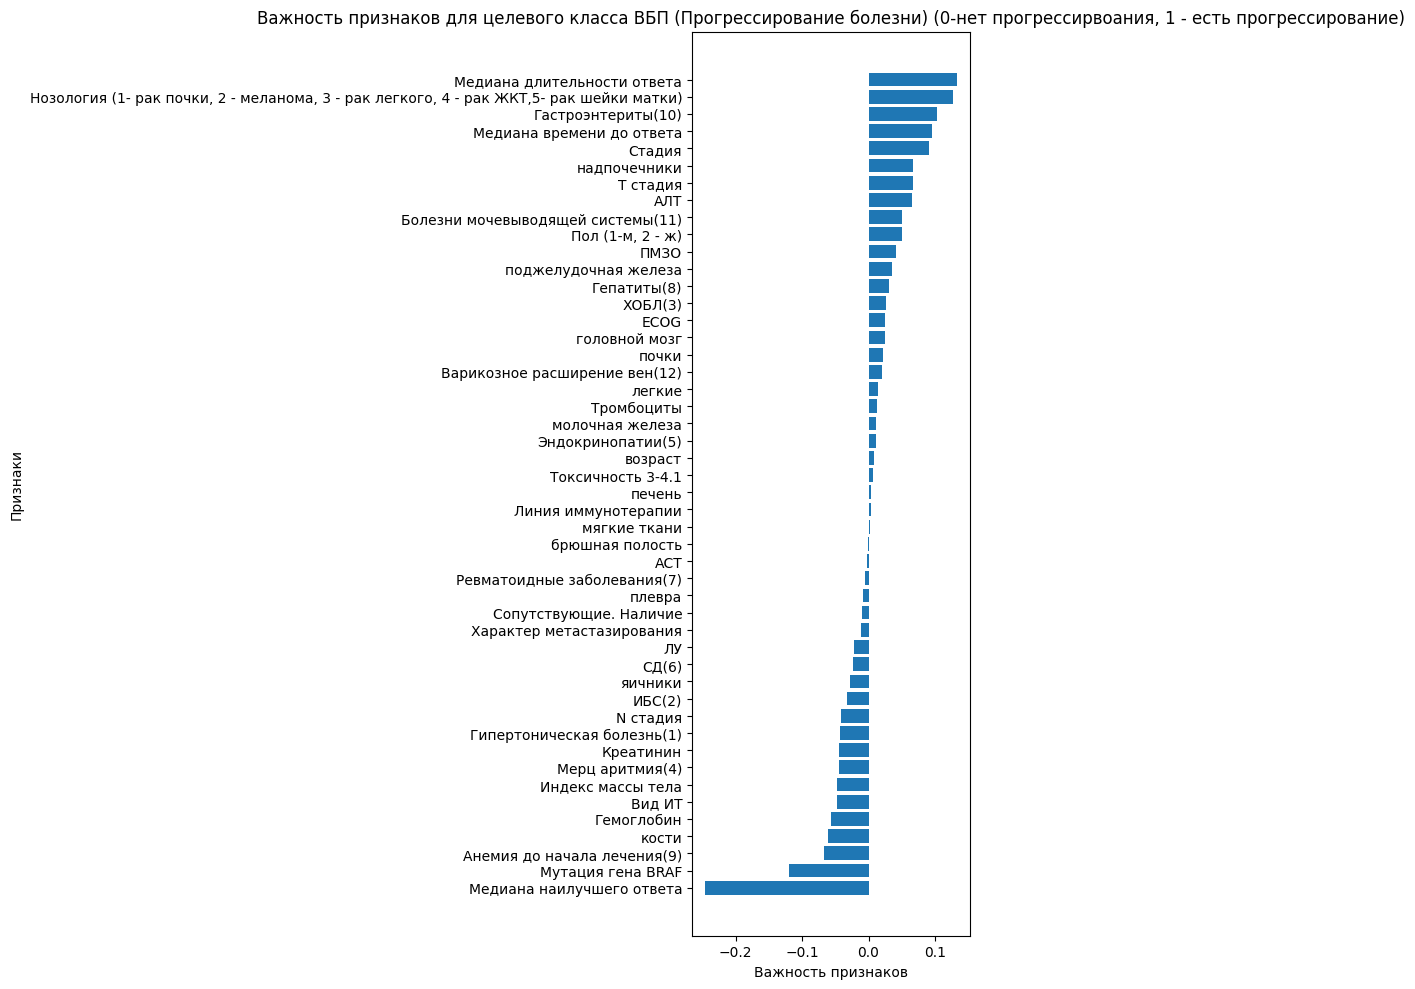

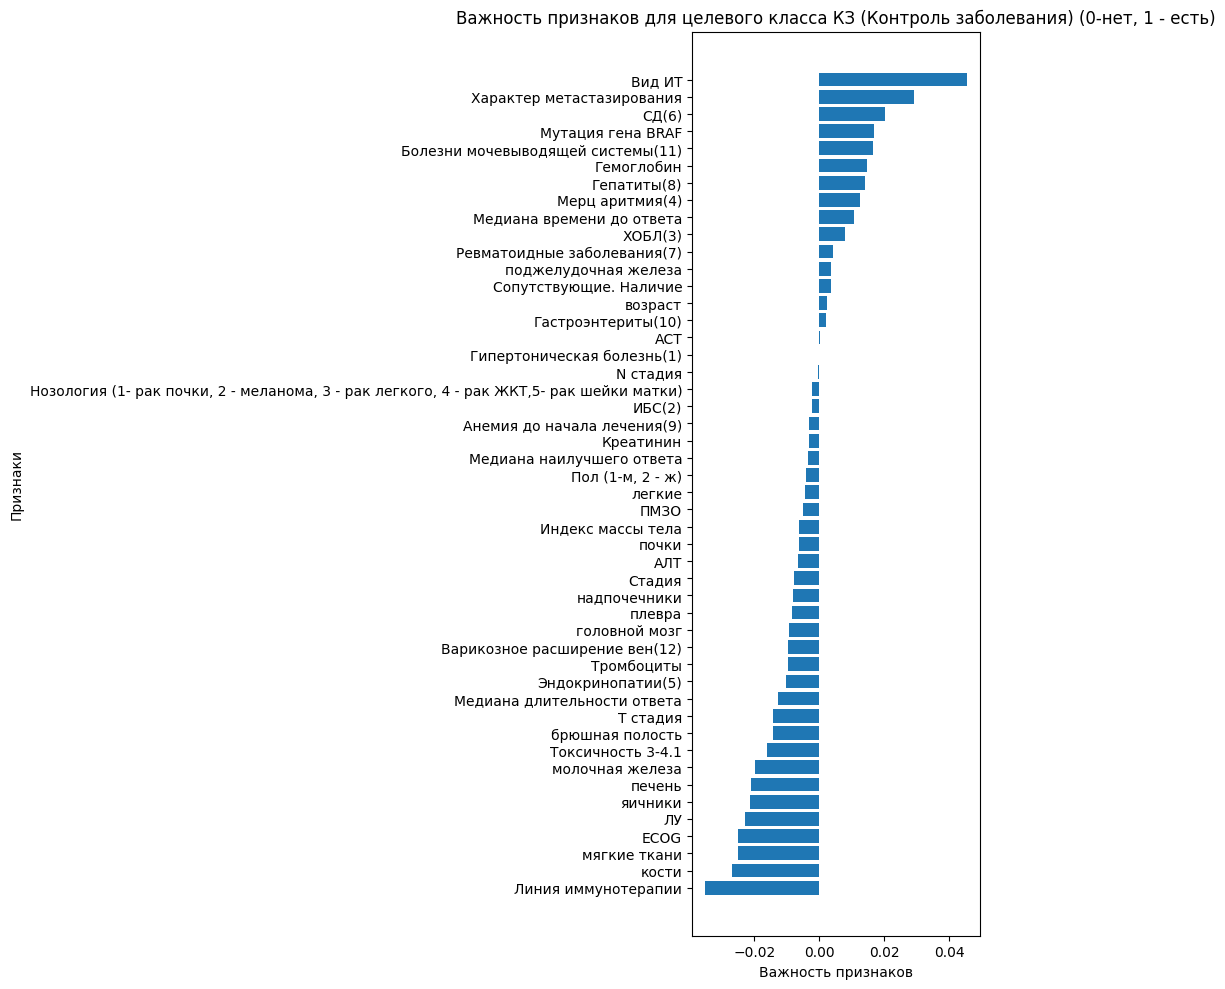

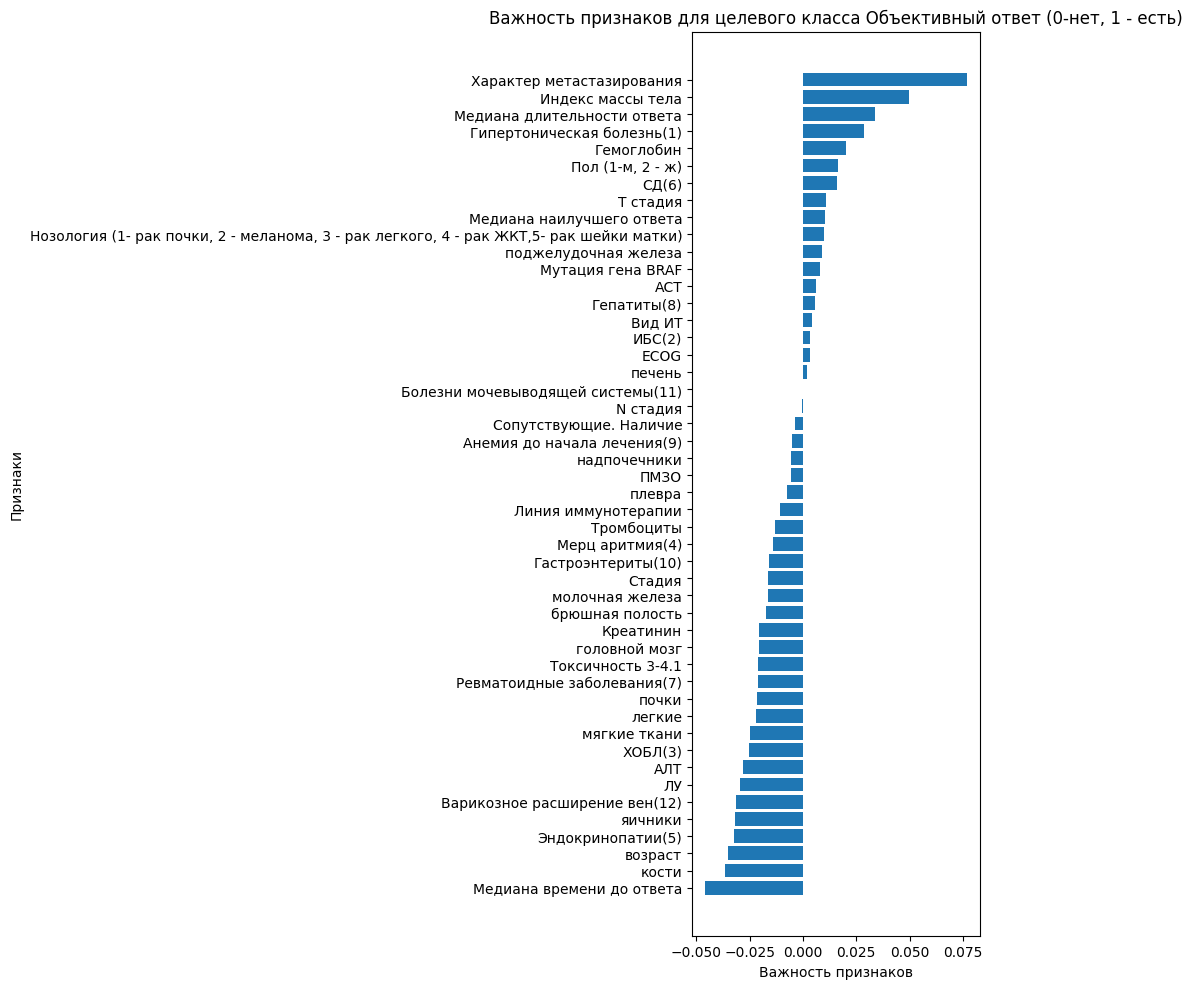

Exception ignored in: <generator object _no_nep50_warning at 0x7b16ddf2f7d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/_ufunc_config.py", line 466, in _no_nep50_warning
    NO_NEP50_WARNING.reset(token)
ValueError: <Token var=<ContextVar name='_no_nep50_warning' default=False at 0x7b17da3db060> at 0x7b16de4f87c0> was created in a different Context


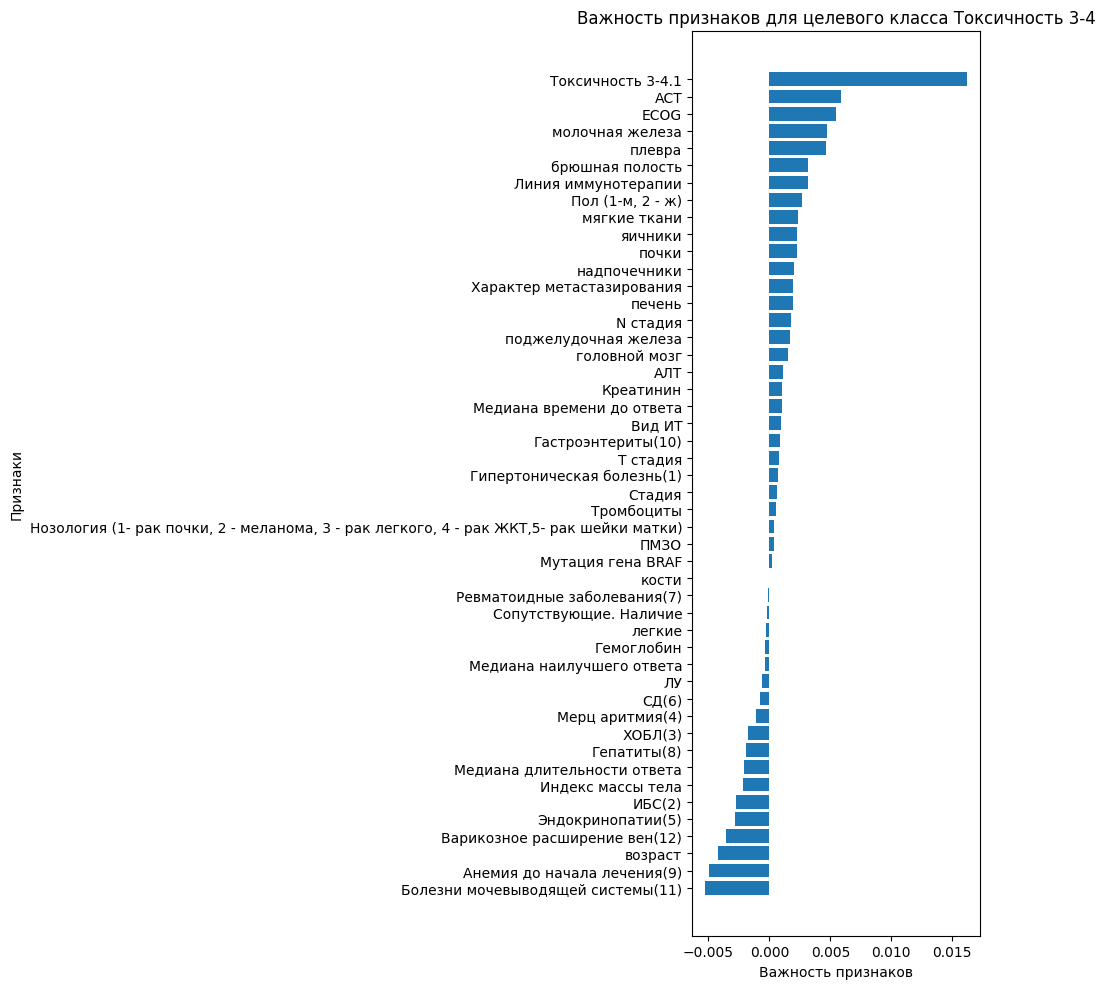

In [ ]:
def grad_cam(model, df_features, df_targets):
    for column in df_targets.columns:
      X_train, X_test, y_train, y_test = train_test_split(df_features, df_targets[column], test_size=0.2, random_state=42, stratify = df_targets[column])
      y_train, y_test = torch.tensor(y_train.values).float(), torch.tensor(y_test.values).float()

      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

      X_train, X_test = torch.tensor(X_train).float(), torch.tensor(X_test).float()

      input_size = df_features.shape[1]
      model = MedicalNN(input_size)

      criterion = nn.BCELoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

      train_model_for_grad_cam(model, X_train, y_train, criterion, optimizer, scheduler)

      x_test_example = X_test[0].unsqueeze(0)  # Пример для одного пациента
      target_class = 0  # Класс, для которого строится карта активации
      cam_result = compute_gradcam(model, x_test_example, target_class)

      # Получаем веса слоев fc1 и fc2
      fc1_weights = model.fc1.weight.detach().cpu().numpy()
      fc2_weights = model.fc2.weight.detach().cpu().numpy()

      # Распространяем важность назад
      fc2_importance = np.dot(cam_result, fc2_weights)
      feature_importance = np.dot(fc2_importance, fc1_weights)

      grad_cam_values = dict(zip(df_features.columns, feature_importance))
      sorted_grad_cam_values = dict(sorted(grad_cam_values.items(), key = lambda item: item[1]))

      barplot(sorted_grad_cam_values, title = f'Важность признаков для целевого класса {column}')

grad_cam(model, df_features, df_targets)

Создадим  Grad-CAM для анализа признаков всех пациентов

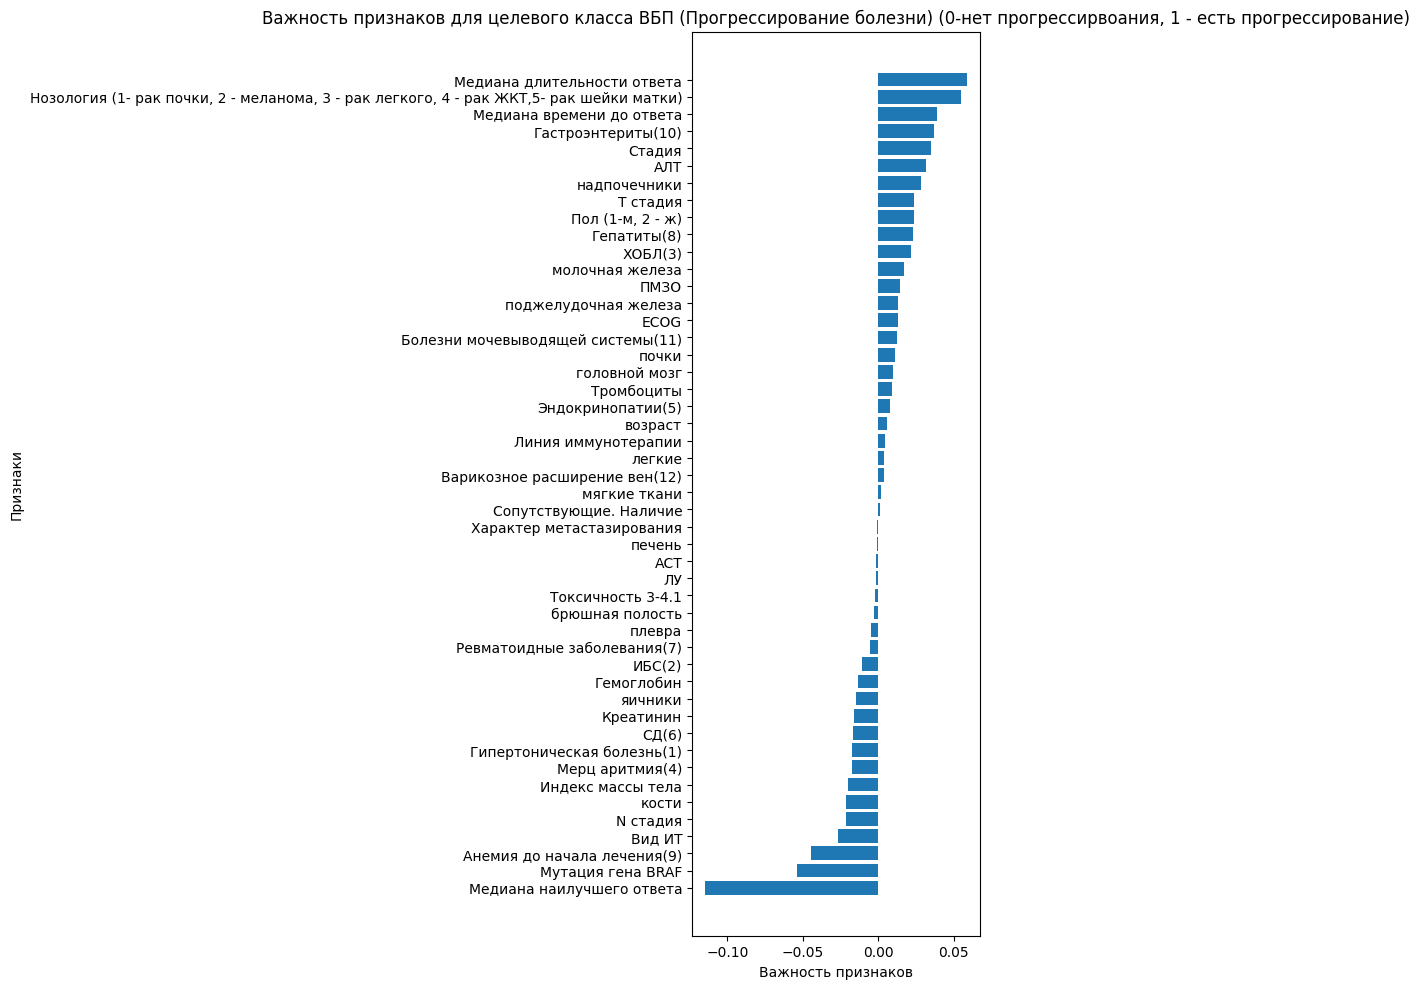

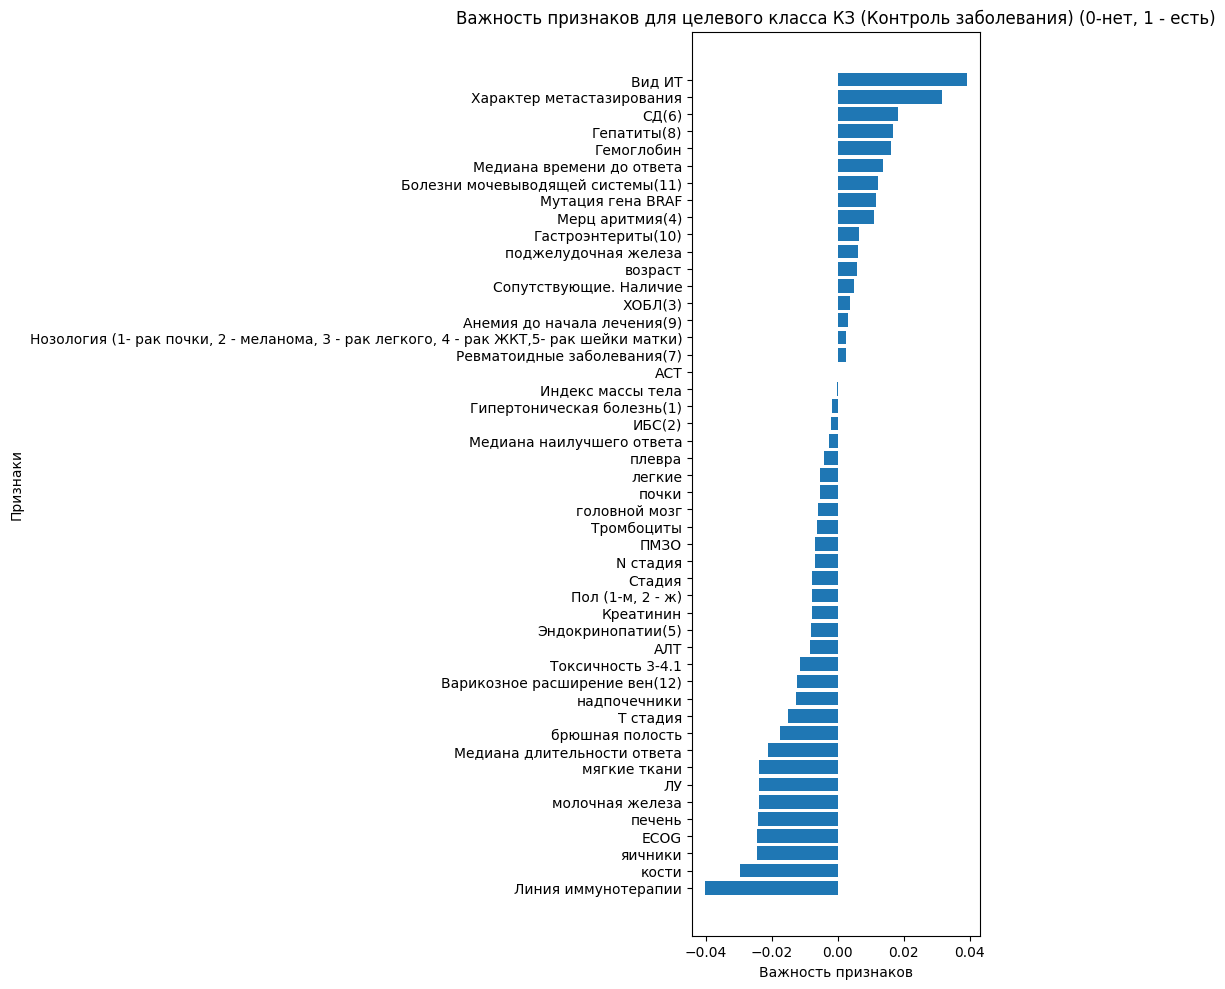

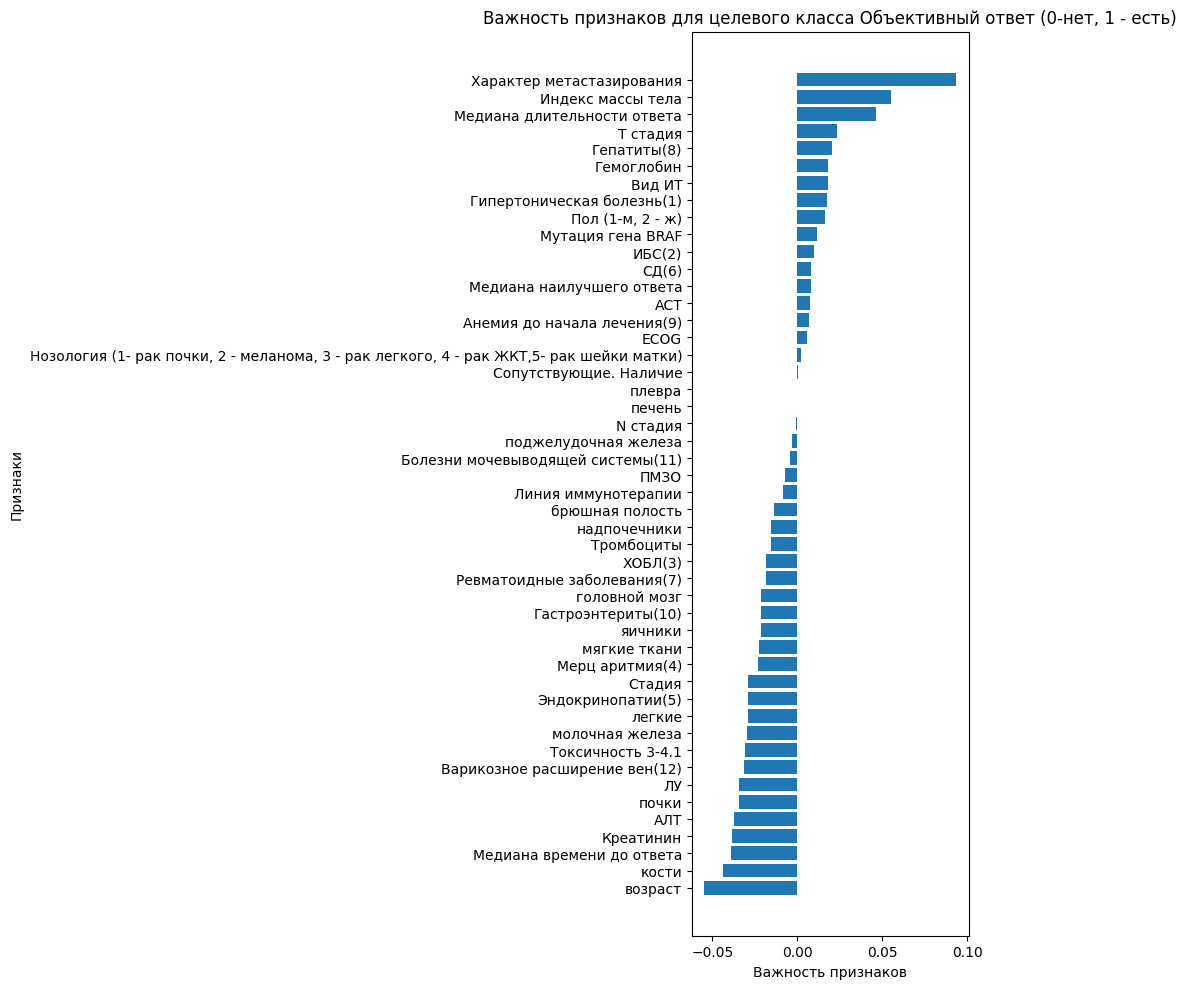

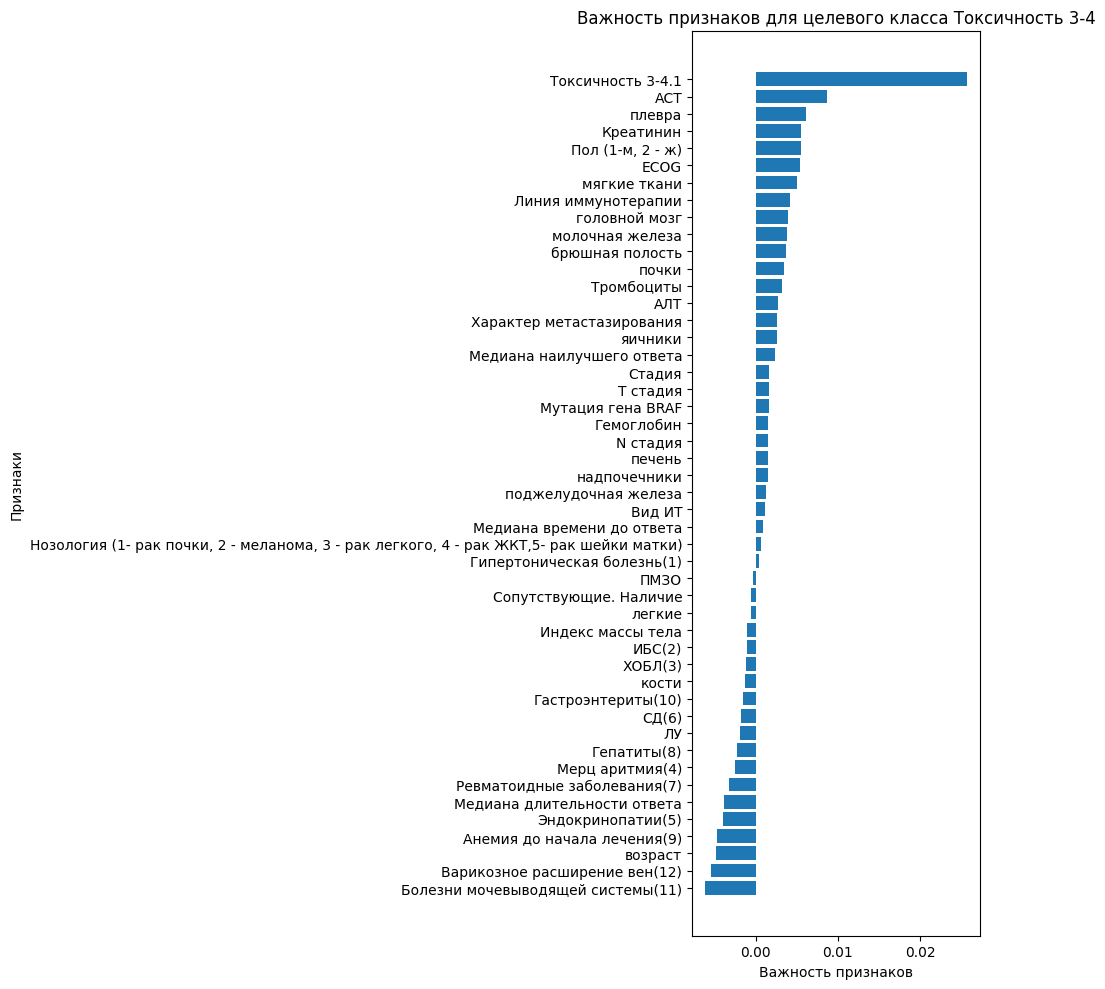

In [ ]:
def grad_cam_all_patient(model, df_features, df_targets):
    for column in df_targets.columns:
      X_train, X_test, y_train, y_test = train_test_split(df_features, df_targets[column], test_size=0.2, random_state=42, stratify = df_targets[column])
      y_train, y_test = torch.tensor(y_train.values).float(), torch.tensor(y_test.values).float()

      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

      X_train, X_test = torch.tensor(X_train).float(), torch.tensor(X_test).float()

      input_size = df_features.shape[1]
      model = MedicalNN(input_size)

      criterion = nn.BCELoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

      train_model_for_grad_cam(model, X_train, y_train, criterion, optimizer, scheduler)

      x_test_example = X_test[0].unsqueeze(0)  # Пример для одного пациента
      target_class = 0  # Класс, для которого строится карта активации
      cam_result = compute_gradcam(model, x_test_example, target_class)

      feature_importance_all = np.zeros(input_size)

      for i in range(len(X_test)):
        x_test_example = X_test[i].unsqueeze(0)
        target_class = 0
        cam_result = compute_gradcam(model, x_test_example, target_class)

        # Получаем веса слоев fc1 и fc2
        fc1_weights = model.fc1.weight.detach().cpu().numpy()
        fc2_weights = model.fc2.weight.detach().cpu().numpy()

        # Распространяем важность назад
        fc2_importance = np.dot(cam_result, fc2_weights)
        feature_importance = np.dot(fc2_importance, fc1_weights)

        feature_importance_all += feature_importance

      feature_importance_avg = feature_importance_all / len(X_test)

      grad_cam_values = dict(zip(df_features.columns, feature_importance_avg))
      sorted_grad_cam_values = dict(sorted(grad_cam_values.items(), key = lambda item: item[1]))

      barplot(sorted_grad_cam_values, title = f'Важность признаков для целевого класса {column}')

grad_cam_all_patient(model, df_features, df_targets)

Визуально видно, что все важные признаки для всех пациентов совпадают с важными признаками для конкретного пацинта выше, разница только в самих значениях.

**SHAP**

Пришлось изменить структуру модели, т.к. Python ругался на метод shap

In [ ]:
class MedicalNN(nn.Module):
    def __init__(self, input_size):
        super(MedicalNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

Важность признаков для целевого класса ВБП (Прогрессирование болезни) (0-нет прогрессирвоания, 1 - есть прогрессирование)


/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


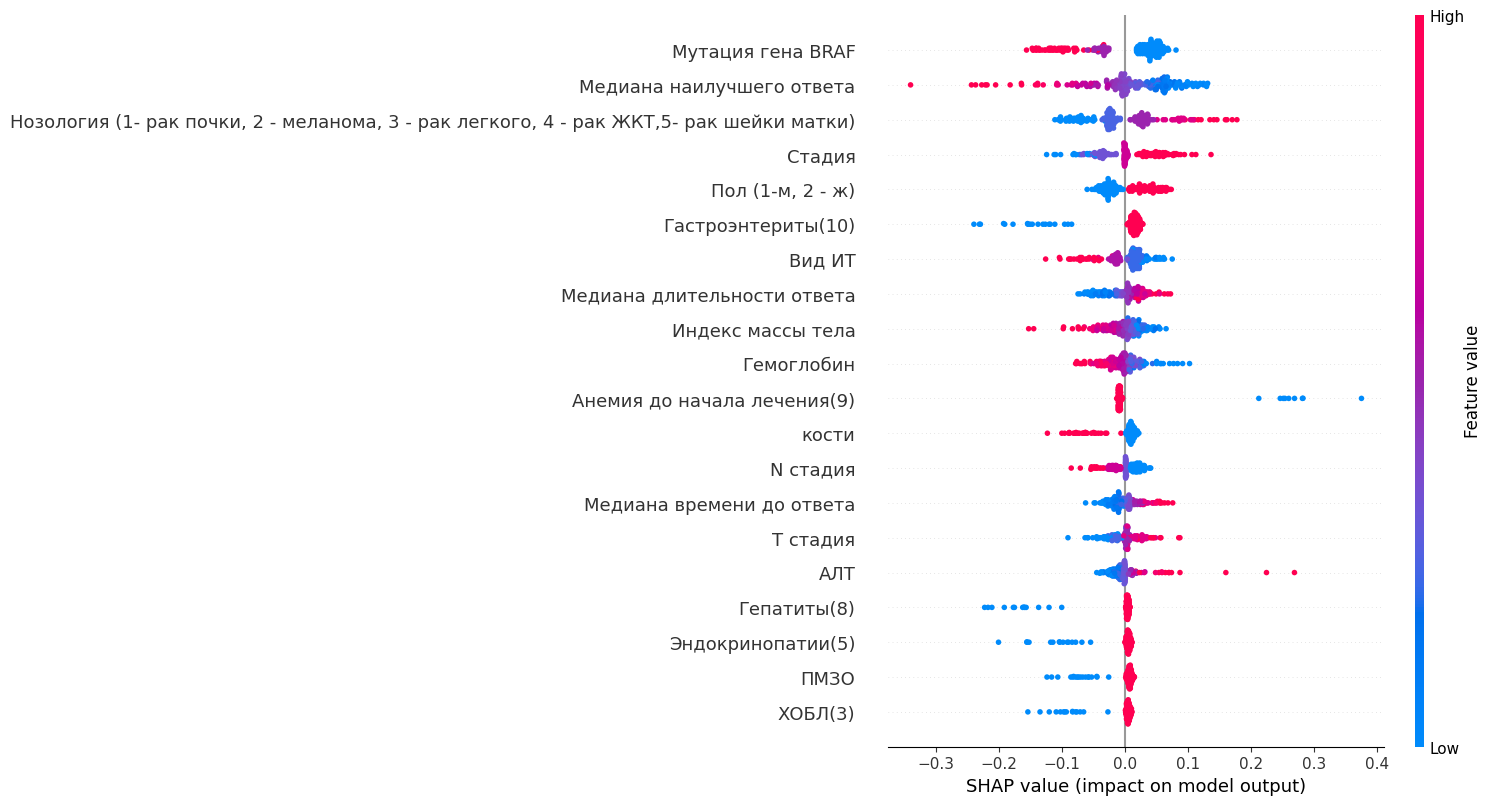

Важность признаков для целевого класса КЗ (Контроль заболевания) (0-нет, 1 - есть)


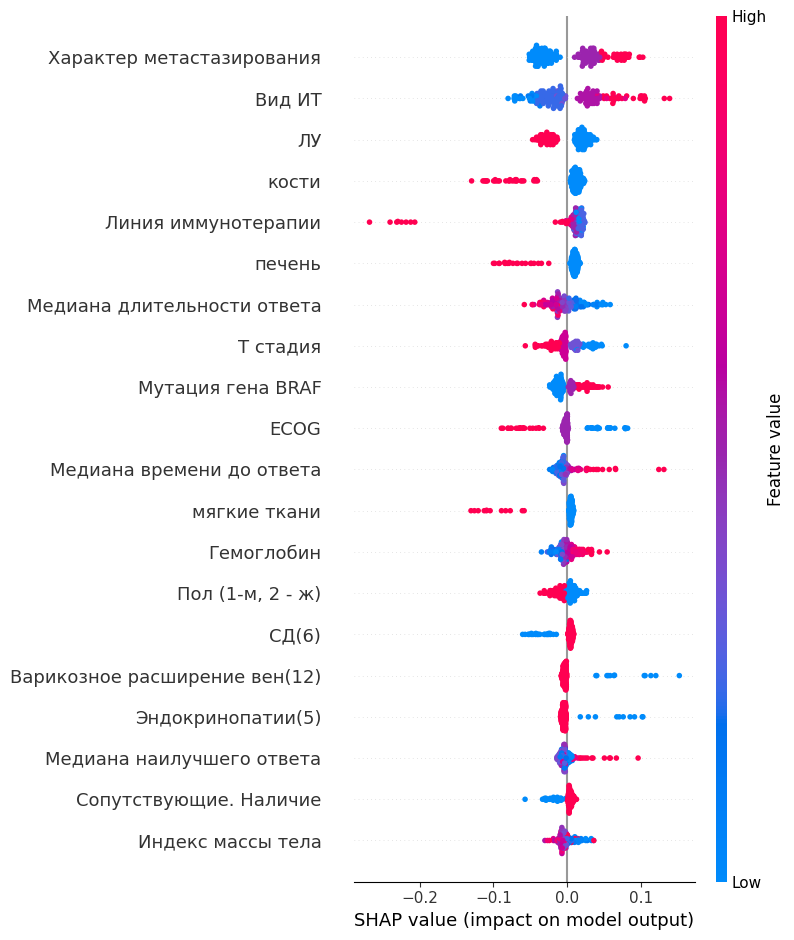

Важность признаков для целевого класса Объективный ответ (0-нет, 1 - есть)


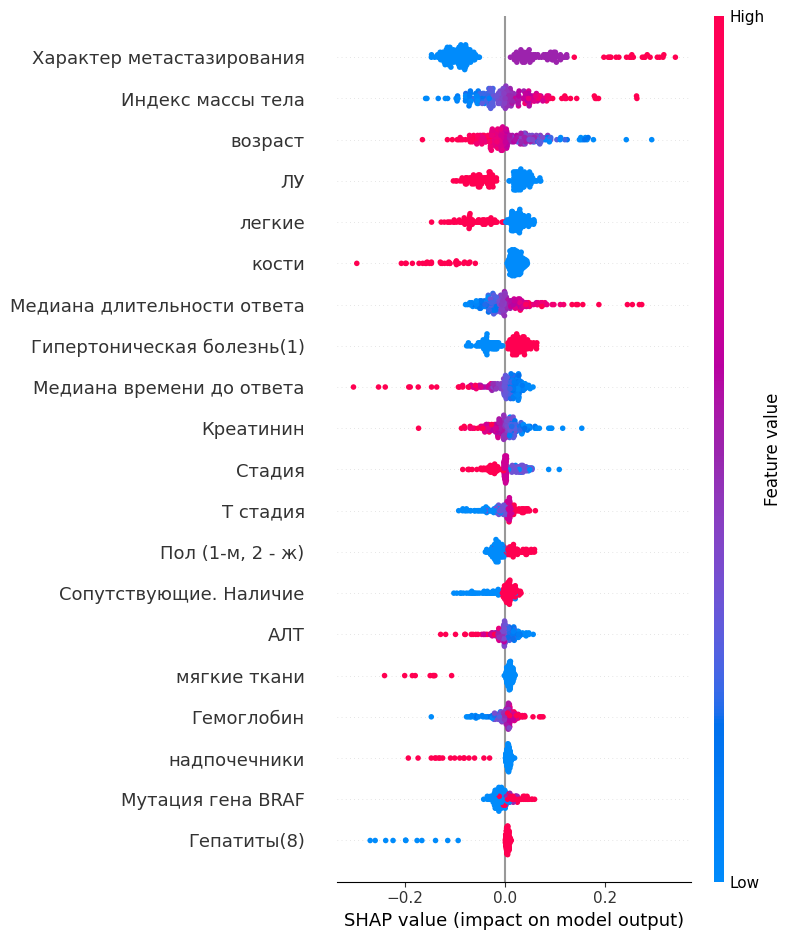

Важность признаков для целевого класса Токсичность 3-4


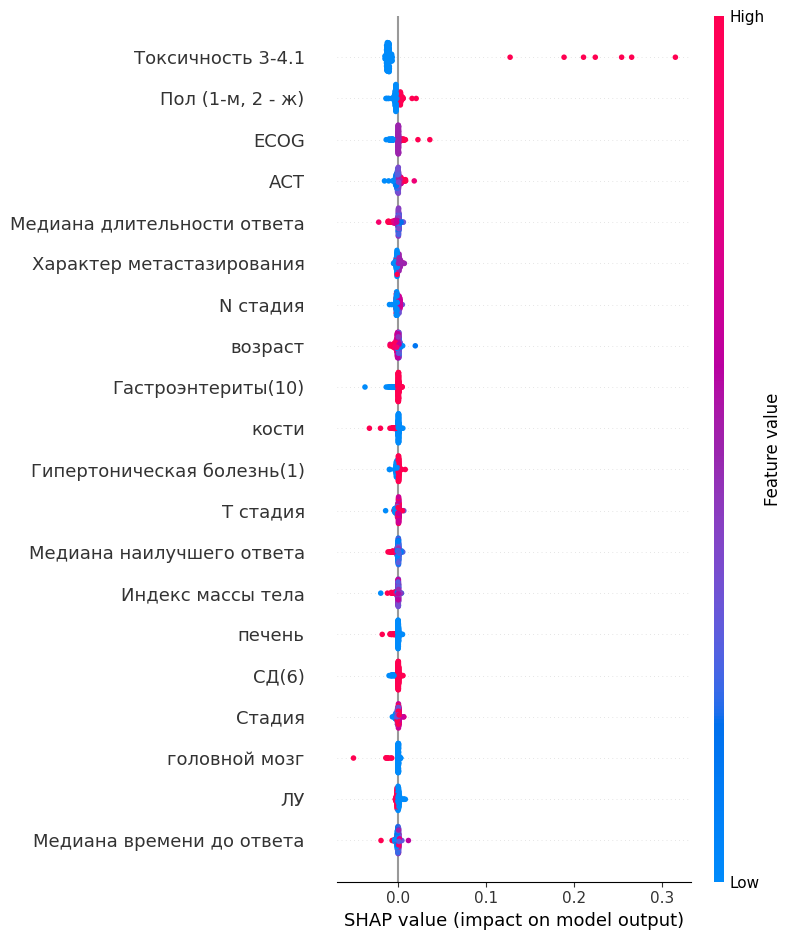

In [ ]:
def shap_plot(column):
    X_train, X_test, y_train, y_test = train_test_split(df_features, df_targets[column], test_size=0.2, random_state=42, stratify = df_targets[column])
    y_train, y_test = torch.tensor(y_train.values).float(), torch.tensor(y_test.values).float()

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train, X_test = torch.tensor(X_train).float(), torch.tensor(X_test).float()

    input_size = df_features.shape[1]
    model = MedicalNN(input_size)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

    train_model_for_grad_cam(model, X_train, y_train, criterion, optimizer, scheduler)

    model.eval()
    explainer = shap.DeepExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)

    print(f'Важность признаков для целевого класса {column}')
    shap.summary_plot(shap_values.squeeze(axis=2), X_test, feature_names=df_features.columns)

for col in df_targets.columns:
    shap_plot(col)

Анализ признаков по grad-cam и shap показал примерно одинаковый результат по значимости признаков для таргетных переменных.

In [ ]:
shap.plots.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0,:,0], X_test[0].detach().cpu().numpy(), feature_names=df_features.columns)

Здесь переменные, которые выделены красным цветом сдвигают предсказание к классу 1, а синие сдвигают предсказание к классу 0 для данного пациента. Base value = 0.34 – среднее значение, полученное при обучении.

**RFE**

In [ ]:
model_rfe_ВБП = LogisticRegression()
model_rfe_КЗ = LogisticRegression()
model_rfe_Ответ = LogisticRegression()
model_rfe_Токсичность = LogisticRegression()

rfe_ВБП = RFE(model_rfe_ВБП, n_features_to_select = 1)
rfe_КЗ = RFE(model_rfe_КЗ, n_features_to_select = 1)
rfe_Ответ = RFE(model_rfe_Ответ, n_features_to_select = 1)
rfe_Токсичность = RFE(model_rfe_Токсичность, n_features_to_select = 1)

rfe_ВБП.fit(df_features, df_targets.iloc[:, 0])
rfe_КЗ.fit(df_features, df_targets.iloc[:, 1])
rfe_Ответ.fit(df_features, df_targets.iloc[:, 2])
rfe_Токсичность.fit(df_features, df_targets.iloc[:, 3])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [ ]:
feature_ranking_ВБП = rfe_ВБП.ranking_
feature_ranking_КЗ = rfe_КЗ.ranking_
feature_ranking_Ответ = rfe_Ответ.ranking_
feature_ranking_Токсичность = rfe_Токсичность.ranking_

rfe_ВБП_dict = dict(zip(df_features.columns, feature_ranking_ВБП))
rfe_КЗ_dict = dict(zip(df_features.columns, feature_ranking_КЗ))
rfe_Ответ_dict = dict(zip(df_features.columns, feature_ranking_Ответ))
rfe_Токсичность_dict = dict(zip(df_features.columns, feature_ranking_Токсичность))

sorted_rfe_ВБП = dict(sorted(rfe_ВБП_dict.items(), key = lambda item: item[1]))
sorted_rfe_КЗ = dict(sorted(rfe_КЗ_dict.items(), key = lambda item: item[1]))
sorted_rfe_Ответ = dict(sorted(rfe_Ответ_dict.items(), key = lambda item: item[1]))
sorted_rfe_Токсичность = dict(sorted(rfe_Токсичность_dict.items(), key = lambda item: item[1]))

In [ ]:
params_rfe = [{'dicts': sorted_rfe_ВБП, 'title': 'Важность признаков для таргета ВБП'},
              {'dicts': sorted_rfe_КЗ, 'title': 'Важность признаков для таргета КЗ'},
              {'dicts': sorted_rfe_Ответ, 'title': 'Важность признаков для таргета Объективный ответ'},
              {'dicts': sorted_rfe_Токсичность, 'title': 'Важность признаков для таргета Токсичность'}
              ]

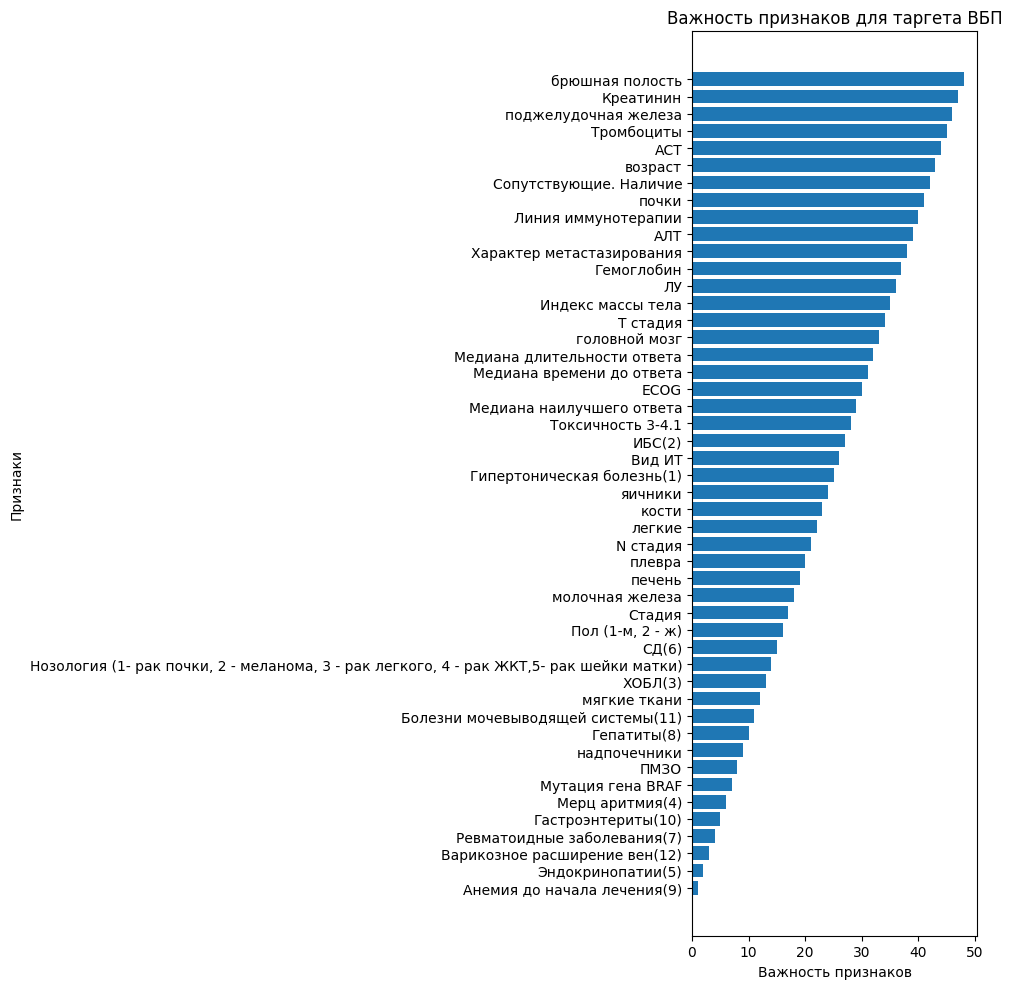

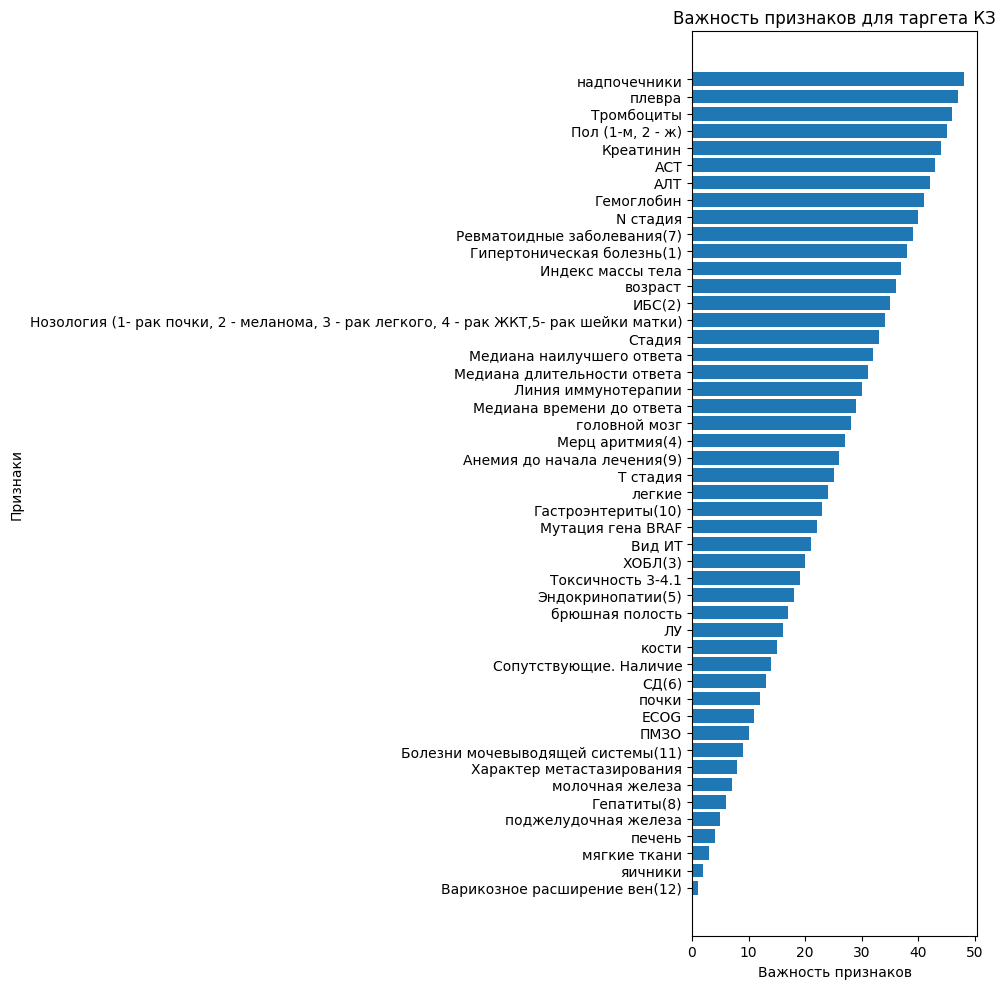

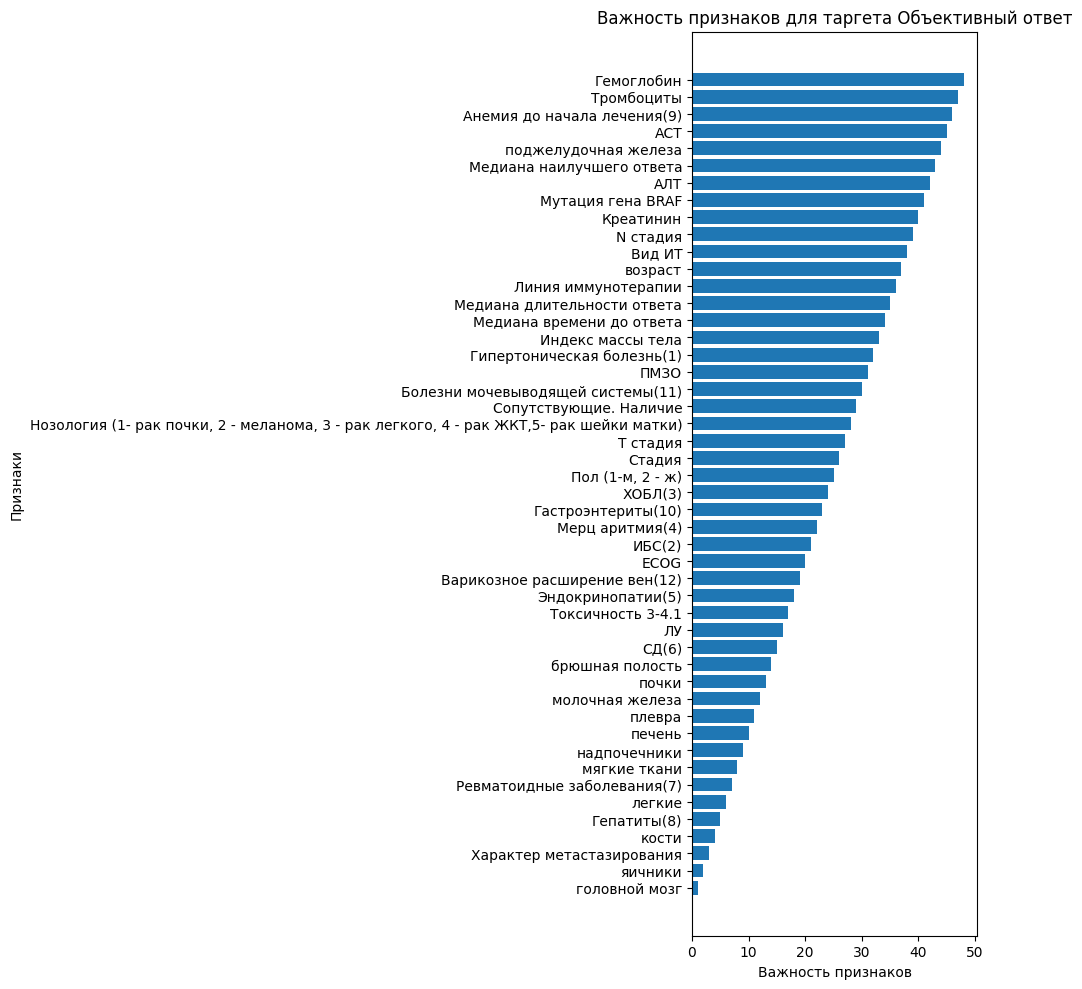

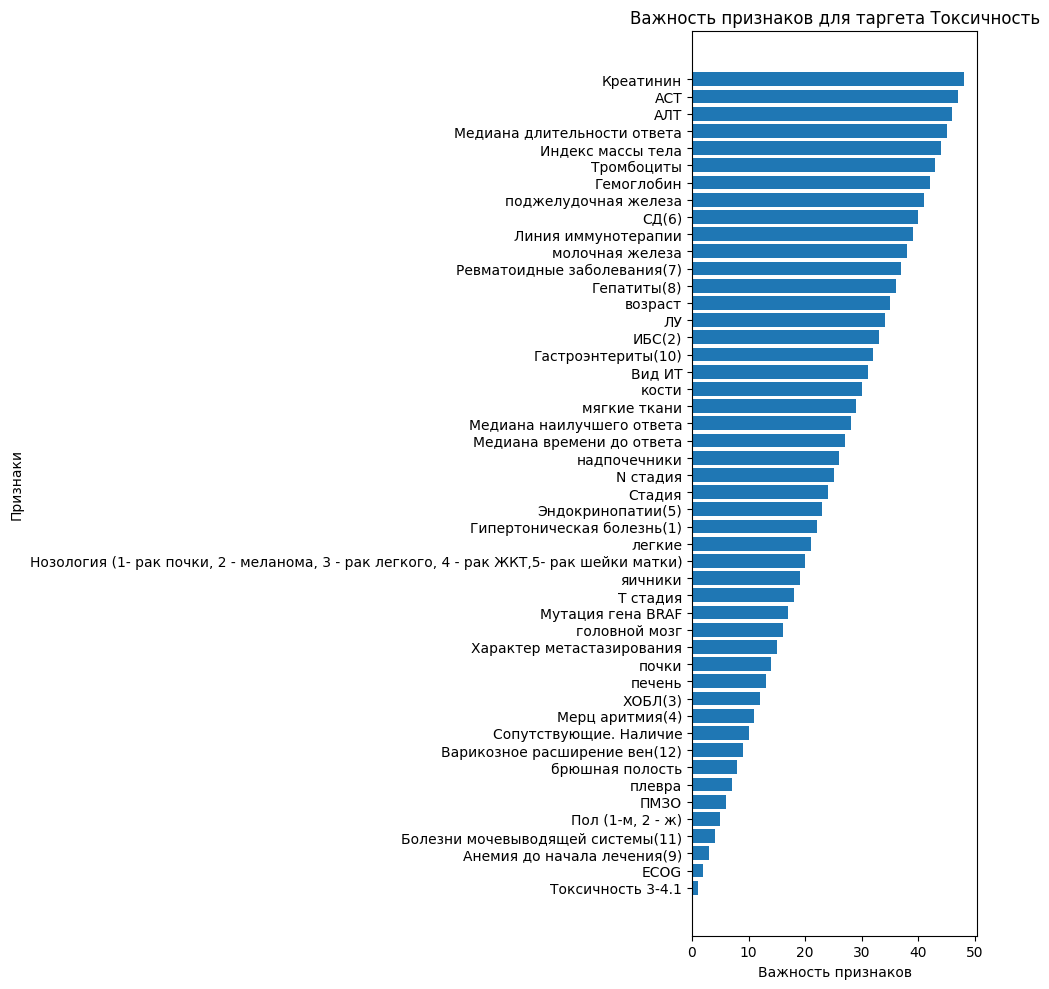

In [ ]:
for params in params_rfe:
    barplot(**params)

Как видно, у каждого таргетной целевой переменной свои важные признаки, хотя в некоторых имеются пересечения по важности, такие как: Креатинин, Тромбоциты, АСТ.

**4. Анализ дерева решений (random forest)**

In [ ]:
X_train_ВБП, X_test_ВБП, y_train_ВБП, y_test_ВБП = train_test_split(df_features, df_targets.iloc[:, 0], test_size=0.2, random_state=42, stratify = df_targets.iloc[:, 0])
X_train_КЗ, X_test_КЗ, y_train_КЗ, y_test_КЗ = train_test_split(df_features, df_targets.iloc[:, 1], test_size=0.2, random_state=42, stratify = df_targets.iloc[:, 1])
X_train_Ответ, X_test_Ответ, y_train_Ответ, y_test_Ответ = train_test_split(df_features, df_targets.iloc[:, 2], test_size=0.2, random_state=42, stratify = df_targets.iloc[:, 2])
X_train_Токсичность, X_test_Токсичность, y_train_Токсичность, y_test_Токсичность = train_test_split(df_features, df_targets.iloc[:, 3], test_size=0.2, random_state=42, stratify = df_targets.iloc[:, 3])

In [ ]:
clf_ВБП = RandomForestClassifier(max_depth=4, random_state=42, criterion = 'gini', n_estimators = 100)
clf_КЗ = RandomForestClassifier(max_depth=4, random_state=42, criterion = 'gini', n_estimators = 100)
clf_Ответ = RandomForestClassifier(max_depth=4, random_state=42, criterion = 'gini', n_estimators = 100)
clf_Токсичность = RandomForestClassifier(max_depth=4, random_state=42, criterion = 'gini', n_estimators = 100)

clf_ВБП.fit(X_train_ВБП, y_train_ВБП)
clf_КЗ.fit(X_train_КЗ, y_train_КЗ)
clf_Ответ.fit(X_train_Ответ, y_train_Ответ)
clf_Токсичность.fit(X_train_Токсичность, y_train_Токсичность)

RandomForestClassifier(max_depth=4, random_state=42)

In [ ]:
accuracy_ВБП = clf_ВБП.score(X_test_ВБП, y_test_ВБП)
accuracy_КЗ = clf_КЗ.score(X_test_КЗ, y_test_КЗ)
accuracy_Ответ = clf_Ответ.score(X_test_Ответ, y_test_Ответ)
accuracy_Токсичность = clf_Токсичность.score(X_test_Токсичность, y_test_Токсичность)

print(f"Точность случайного леса для ВБП: {accuracy_ВБП:.4f}")
print(f"Точность случайного леса для КЗ: {accuracy_КЗ:.4f}")
print(f"Точность случайного леса для Ответ: {accuracy_Ответ:.4f}")
print(f"Точность случайного леса для Токсичность: {accuracy_Токсичность:.4f}")

Точность случайного леса для ВБП: 0.6915
Точность случайного леса для КЗ: 0.8209
Точность случайного леса для Ответ: 0.7761
Точность случайного леса для Токсичность: 0.9701


In [ ]:
importances_ВБП = clf_ВБП.feature_importances_
importances_КЗ = clf_КЗ.feature_importances_
importances_Ответ = clf_Ответ.feature_importances_
importances_Токсичность = clf_Токсичность.feature_importances_

In [ ]:
importances_ВБП_dict = dict(zip(df_features.columns, importances_ВБП))
importances_КЗ_dict = dict(zip(df_features.columns, importances_КЗ))
importances_Ответ_dict = dict(zip(df_features.columns, importances_Ответ))
importances_Токсичность_dict = dict(zip(df_features.columns, importances_Токсичность))

In [ ]:
sorted_importances_ВБП = dict(sorted(importances_ВБП_dict.items(), key = lambda item: item[1]))
sorted_importances_КЗ = dict(sorted(importances_КЗ_dict.items(), key = lambda item: item[1]))
sorted_importances_Ответ = dict(sorted(importances_Ответ_dict.items(), key = lambda item: item[1]))
sorted_importances_Токсичность = dict(sorted(importances_Токсичность_dict.items(), key = lambda item: item[1]))

In [ ]:
params_clf = [{'dicts': sorted_importances_ВБП, 'title': 'Важность признаков для таргета ВБП'},
              {'dicts': sorted_importances_КЗ, 'title': 'Важность признаков для таргета КЗ'},
              {'dicts': sorted_importances_Ответ, 'title': 'Важность признаков для таргета Объективный ответ'},
              {'dicts': sorted_importances_Токсичность, 'title': 'Важность признаков для таргета Токсичность'}
              ]

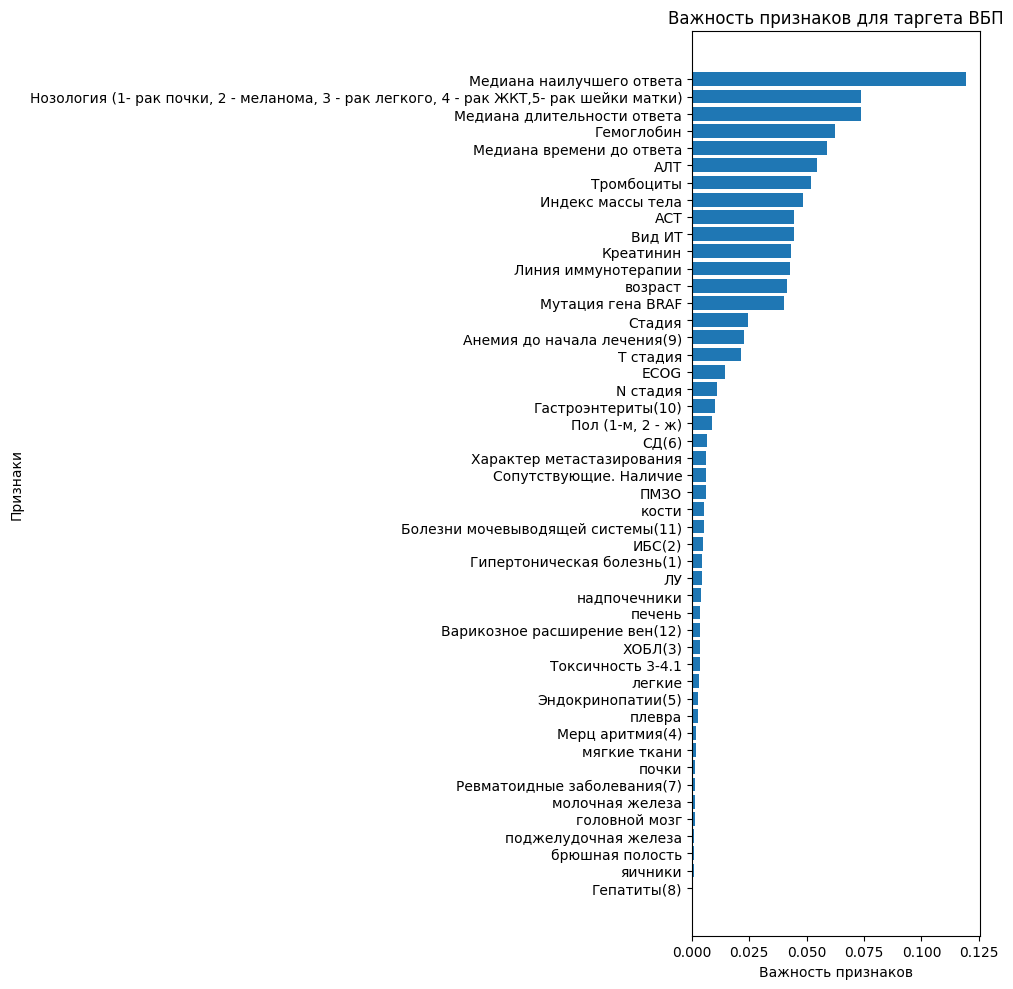

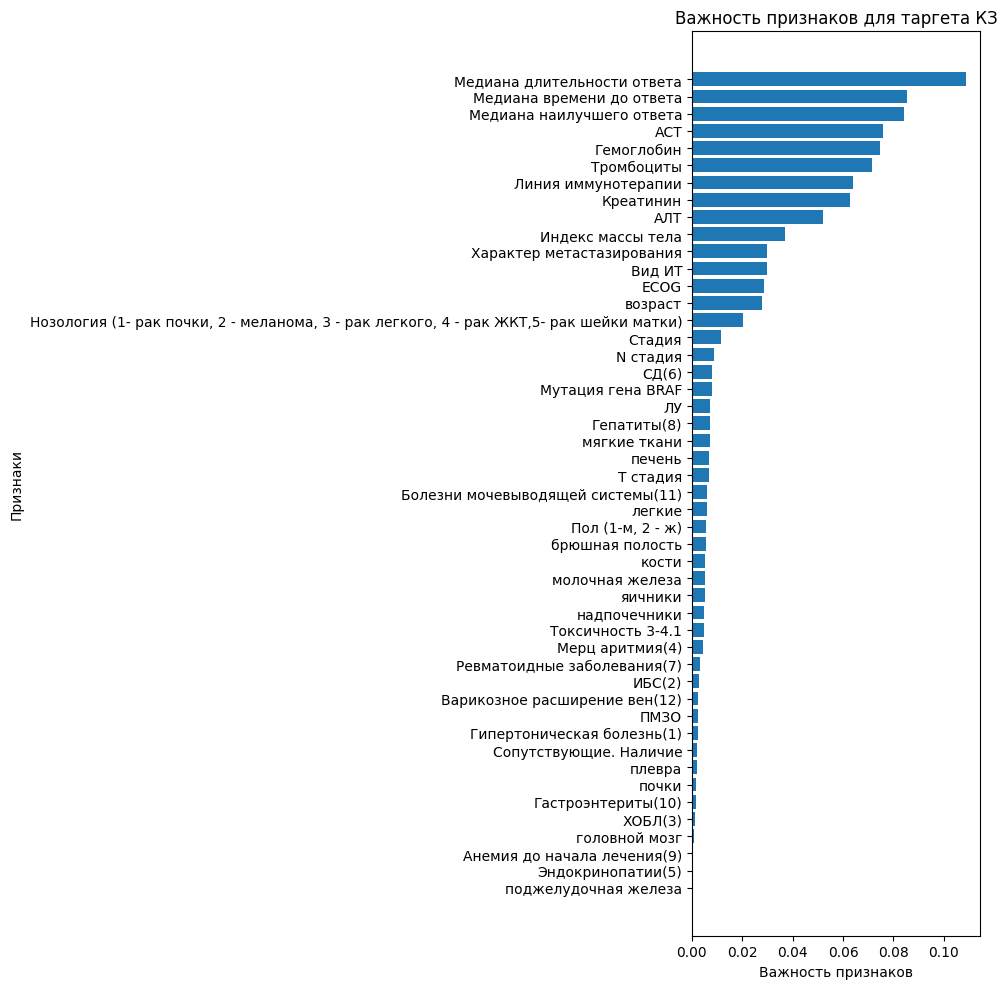

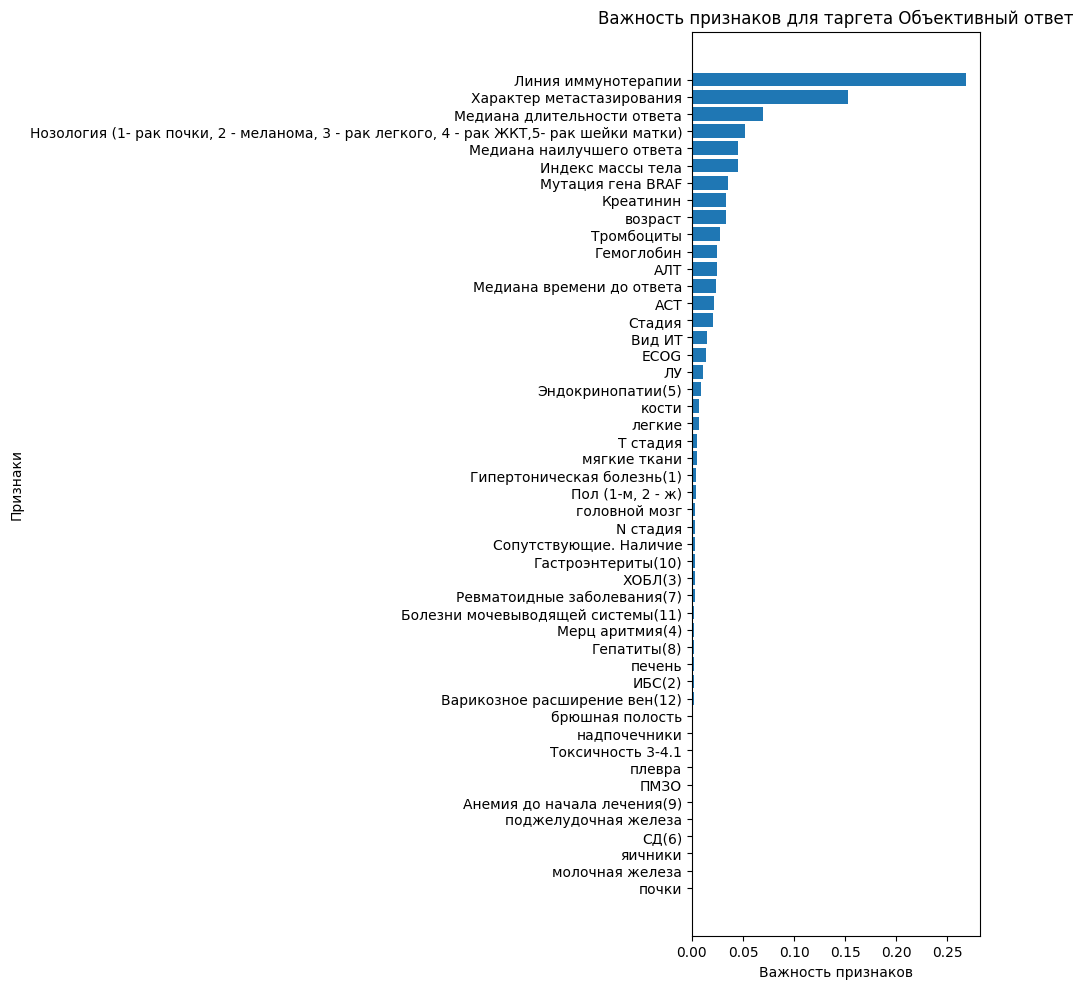

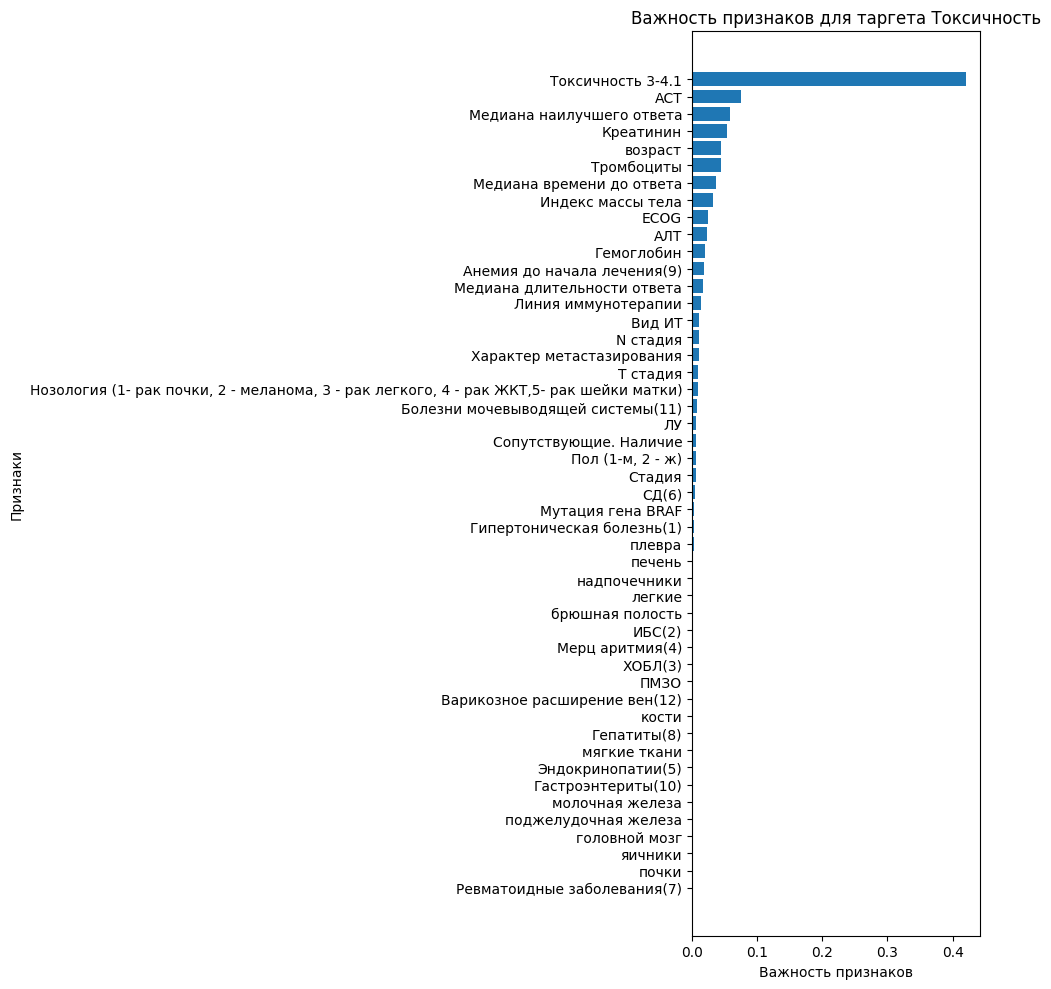

In [ ]:
for params in params_clf:
    barplot(**params)

В деревьях у каждого таргетной переменной имеется разное количество важных признаков. Например в Токсичность в основном используется только признак Токсичность 3-4.1 для предсказания.

Таким образом, в разных моделях могут использоваться различные методы отбора признаков. Необходимо экспериментировать с несколькими методами отбора признаков и оценивать их влияние на качество модели.